In [1]:
%pylab inline
import sys
sys.path.append('../build_gcc/')
import versor as vsr
from liblds_calibration import (LaserDistanceSensorCalibrator, transform_tangent_vector)
from game import solver_options

Populating the interactive namespace from numpy and matplotlib


versor/cga.py:4: RuntimeWarning: to-Python converter for vsr::Multivector<vsr::algebra<vsr::metric<4, 1, true>, double>, vsr::Basis<(short)1, (short)2, (short)4, (short)8, (short)16> > already registered; second conversion method ignored.
  from libversor import (Biv, Bst, Cir, Con, Dil, Dll, Dlp, Dls, Drb, Drt, Drv,
versor/cga.py:4: RuntimeWarning: to-Python converter for vsr::Multivector<vsr::algebra<vsr::metric<4, 1, true>, double>, vsr::Basis<(short)9, (short)10, (short)12> > already registered; second conversion method ignored.
  from libversor import (Biv, Bst, Cir, Con, Dil, Dll, Dlp, Dls, Drb, Drt, Drv,


# Laser Distance Sensor Calibration

$$ R = \frac{1 + \mathrm{b}\mathrm{a}}{\sqrt{2(1 + \mathrm{b} \rfloor \mathrm{a})}} $$

In [2]:
rotor_from_vectors = lambda a, b: (b * a + 1) / np.sqrt(2*(1+(b <= a)[0]))

## Create measurement poses

In [182]:
# laser direction in end-effector
l0 = vsr.Vec(1,0,0).spin( vsr.Rot.from_bivector(vsr.Biv(1,0,0) * pi/ 3))
p0 = vsr.Vec(0.1,0.2,0.3)
R0 = rotor_from_vectors(vsr.Vec(1,0,0), l0)
T0 = vsr.Trs.from_vector(p0)
M_laser_in_ee = T0 * R0
print(M_laser_in_ee)

0.866025  -0.5  0  0  -0.0933013  -0.0616025  -0.129904  0.075  


In [333]:
# Laser sensor
# lower = 0.065
# upper = 0.095

lower = 0.01
upper = lower + 0.2
generate_measurement_distance = lambda : (upper - lower) * np.random.rand() + lower

In [334]:
def create_point_on_sphere():
    r = generate_measurement_distance()
    theta = np.random.rand() * np.pi / 2.0
    phi = np.random.rand() * np.pi * 2.0 
    return vsr.Vec(r*np.sin(theta)*np.cos(phi),
                   r*np.sin(theta)*np.sin(phi),
                   r*np.cos(theta)), r

Create point on upper hemisphere on measurement sphere:

$$ 
x = r \sin (\theta) \cos(\varphi),\
y = r \sin (\theta) \cos(\varphi),\ 
z = r \cos(\varphi) 
$$

In [335]:
def generate_measurement_pose_and_plane_and_distance(M_laser_in_ee):
    # Model laser as tangent vector in the e_1-direction at the origin
    lds_dir = vsr.Vec(1,0,0)
    lds_tnv = vsr.no ^ lds_dir
    # Model the measurement plane as plane through the orgin with
    # normal vector \hat{n} = e_3
    dlp = dlp = vsr.Dlp(0,0,1,0)
    # Create point on upper hemisphere of measurement sphere with 
    # radius equals the measurement distance
    p, radius = create_point_on_sphere()
    # Compute motor that aligns lds_dir with measurement vector from 
    # from point on circle to the origin
    R = rotor_from_vectors(lds_dir, -p.unit())
    T = vsr.Trs.from_vector(p)
    M_on_sphere = T * R * vsr.Rot.from_bivector(vsr.Vec(1,0,0).duale() * 
                                                np.random.rand() * 2 * pi)
    # Transform the everything the measurement plane
    x_in_plane = np.random.rand()
    y_in_plane = np.random.rand()
    T_in_plane = vsr.Trs.from_vector(vsr.Vec(x_in_plane, y_in_plane, 0.0)) * vsr.Rot(1.0,0.0,0.0,0.0)
    # Transform the plane
    M_plane = vsr.Mot.from_dir_ang_trs(vsr.Vec(0,1,0), np.pi/4, vsr.Vec(1,1,0.5))
    dlp_meas = dlp.spin(M_plane)
    M2 = M_plane * T_in_plane * M_on_sphere * M_laser_in_ee.rev()   
    return M2, dlp_meas, radius

In [336]:
M, dlp, r = generate_measurement_pose_and_plane_and_distance(M_laser_in_ee)
t2 = transform_tangent_vector(M * M_laser_in_ee,  (vsr.no ^ vsr.Vec(1,0,0)))
s = (dlp <= t2) / (vsr.ni <= (dlp <= t2))[0]
np.allclose(r, np.sqrt((s <= s)[0]))

True

In [337]:
measurements = [generate_measurement_pose_and_plane_and_distance(M_laser_in_ee) for i in range(1000)]

In [338]:
options = solver_options()
options['function_tolerance'] = 1e-12
options['parameter_tolerance'] = 1e-12
options['max_num_iterations'] = 100
options['num_linear_solver_threads'] = 100
options['num_threads'] = 100

In [346]:
# M_error = vsr.Mot.from_dir_ang_trs(vsr.Vec(1,1,1).unit(), pi/12, [0.01, 0.01, 0.01])
# laser direction in end-effector
l = vsr.Vec(1,0,0).unit().spin( vsr.Rot.from_bivector(vsr.Biv(1,0.0,0).unit() * (pi/3 + np.deg2rad(0)) ))
p = vsr.Vec(0.1 + 0.001 ,0.2 + 0.001,0.3 + 0.001)
R = rotor_from_vectors(vsr.Vec(1,0,0), l)
T = vsr.Trs.from_vector(p)
M_initial = T * R
print(M_initial)
print(M_laser_in_ee)
lds_calibrator = LaserDistanceSensorCalibrator(M_initial, options)

0.866025  -0.5  0  0  -0.0939843  -0.0617856  -0.130337  0.07525  
0.866025  -0.5  0  0  -0.0933013  -0.0616025  -0.129904  0.075  


In [347]:
for measurement in measurements:
    lds_calibrator.add_residual_block(*measurement)

In [348]:
# lds_calibrator.set_parameterization('POLAR_DECOMPOSITION')

In [349]:
lds_calibrator.set_parameterization('BIVECTOR_GENERATOR_ADEPT')

In [350]:
motor, summary = lds_calibrator.solve()

In [351]:
print(summary['full_report'])
print(motor)


Solver Summary (v 1.10.0-eigen-(3.2.0)-lapack-suitesparse-(4.2.1)-openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                          1000                     1000
Residual                                 1000                     1000

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                   100                      100
Linear solver threads                     100                      100

Cost:
Initial                          7.322036e-02
Final               

In [352]:
print M_laser_in_ee

0.866025  -0.5  0  0  -0.0933013  -0.0616025  -0.129904  0.075  


In [353]:
errors = []
for measurement in measurements:
    dlp = measurement[1]
    t = transform_tangent_vector(measurement[0] * motor,  (vsr.no ^ vsr.Vec(1,0,0)))
    s = (dlp <= t) / (vsr.ni <= (dlp <= t))[0]
    r_est = np.sqrt((s <= s)[0])
    errors.append(np.abs(r_est - measurement[2]))
print(np.sum(errors) / 1000)

0.000454412793731


In [354]:
print(vsr.Vec(0,0,0).null().spin(motor))

0.100374  0.199926  0.300218  1  0.0700882  


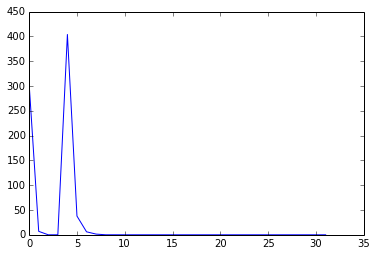

In [355]:
iterations = summary['iterations']
plot([it['gradient_max_norm'] for it in iterations])